## Part I: Preparing Data

In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid", font_scale=1.3)
sns.set_style({"font.family": "serif"})

import warnings
warnings.filterwarnings("ignore")

### Loading data

Датасет давайте возьмём довольно релевантный реальной жизни; он доступен по следующей ссылке:
https://ourworldindata.org/coronavirus-source-data


In [2]:
DATA_PATH = "/content/drive/MyDrive/coronavirus-source-data/owid-covid-data.csv"

data_pd = pd.read_csv(DATA_PATH)

Выберем из таблицы данные по России, начиная с `3 марта 2020 г.` (в этот момент впервые стало больше 2 заболевших).

In [3]:
data_pd["date"] =  pd.to_datetime(data_pd["date"]).dt.normalize()

In [4]:
data_pd["date"]

0        2020-02-24
1        2020-02-25
2        2020-02-26
3        2020-02-27
4        2020-02-28
            ...    
166549   2022-03-02
166550   2022-03-03
166551   2022-03-04
166552   2022-03-05
166553   2022-03-06
Name: date, Length: 166554, dtype: datetime64[ns]

In [5]:
rus_march_mask = (
    (data_pd["date"] >= "2020-03-03") & 
    (data_pd["location"] == "Russia")
)
data_pd = data_pd[rus_march_mask].reset_index()

Даны данные за 734 дня

In [6]:
data_pd['date'].nunique()

734

In [7]:
data_pd.shape

(734, 68)

In [8]:
data_pd.sample(3)

,index,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
690,124645,RUS,Europe,Russia,2022-01-22,10860799.0,56767.0,38338.000,318869.0,669.0,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
126,124081,RUS,Europe,Russia,2020-07-07,693215.0,6363.0,6612.286,10478.0,198.0,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
40,123995,RUS,Europe,Russia,2020-04-12,15770.0,2186.0,1483.000,130.0,24.0,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN


Для упрощения обработки заменим в столбце `new_cases` все нули на единицы

In [9]:
data_pd.loc[(data_pd.new_cases == 0), "new_cases"] = 1

### Training & testing samples

Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта. Остальные данные используем в качестве тестового набора

In [10]:
train_date_begin = data_pd["date"].min().normalize()
train_date_end = train_date_begin + pd.DateOffset(days=49)
test_date_begin = train_date_end + pd.DateOffset(days=1)
test_date_end = data_pd["date"].max().normalize()

print("train_date_begin:", train_date_begin)
print("train_date_end", train_date_end)

print("test_date_begin:", test_date_begin)
print("test_date_end", test_date_end)

train_date_begin: 2020-03-03 00:00:00
train_date_end 2020-04-21 00:00:00
test_date_begin: 2020-04-22 00:00:00
test_date_end 2022-03-06 00:00:00


In [11]:
def train_test_split(feature_matrix, target, 
                     train_date_begin, train_date_end,
                     test_date_begin, test_date_end):
    "The date column of feature matrix must be set to index."
    train_X = feature_matrix.loc[train_date_begin:train_date_end]
    test_X = feature_matrix.loc[test_date_begin:test_date_end]
    train_y = target.loc[train_date_begin:train_date_end]
    test_y = target.loc[test_date_begin:test_date_end]
    return train_X, test_X, train_y, test_y

In [12]:
data_pd = data_pd.set_index("date")

In [13]:
train_X, test_X, train_y, test_y = train_test_split(
    data_pd.drop(["total_cases", "new_cases"], axis=1),
    data_pd.loc[:, ["total_cases", "new_cases"]],
    train_date_begin, train_date_end,  
    test_date_begin, test_date_end
)

In [14]:
print(
    f"""
    Размеры выборок, (объекты, признаки).
    - Обучающая: {train_X.shape}
    - Тестовая: {test_X.shape}
    """
)


    Размеры выборок, (объекты, признаки).
    - Обучающая: (50, 65)
    - Тестовая: (684, 65)
    


## Part II: Bayesian Linear Regression

### Target distributions on training & testing samples

In [15]:
def plot_target_distributions(fig, ax, data, target_names, 
                              titles, colors, suptitle, 
                              xlabel, ylabel):
    fig.subplots_adjust(bottom=0.2, top=0.85, wspace=0.1)
    fig.suptitle(suptitle, fontsize=25)
    fig.align_labels(axs=ax)
    if len(target_names) == 1:
        ax = [ax]

    for i, target_name in enumerate(target_names):
        ax[i].set_title(f"{target_name}", fontsize=22, pad=10)
        ax[i].set_xlabel(xlabel, fontsize=22, labelpad=10)
        ax[i].set_ylabel(ylabel, fontsize=22, labelpad=10)
        ax[i].ticklabel_format(style='sci', axis='y')
    ax[0].yaxis.set_label_position("left")
    if len(target_names) > 1:
        ax[1].yaxis.set_label_position("right")
        ax[1].yaxis.tick_right()

    for i, target_name in enumerate(target_names):
        for sample_type in data.keys():
            ax[i].scatter(
                x=data[sample_type].index,
                y=data[sample_type].loc[:, target_name], 
                label=sample_type, 
                color=colors[sample_type], 
                edgecolor="gold", lw=0.2,
            )
            ax[i].plot(data[sample_type].index, data[sample_type].loc[:, target_name], 
                color=colors[sample_type], lw=0.5,
            )
        
        legend = ax[i].legend(framealpha=1)
        frame = legend.get_frame()
        frame.set_facecolor("white")
        frame.set_edgecolor("black")
        
        vals = ax[i].get_yticks()
        ax[i].set_yticklabels(["{:,.10}".format(x) for x in vals])
        ax[i].xaxis.set_tick_params(rotation=45)

    plt.show()

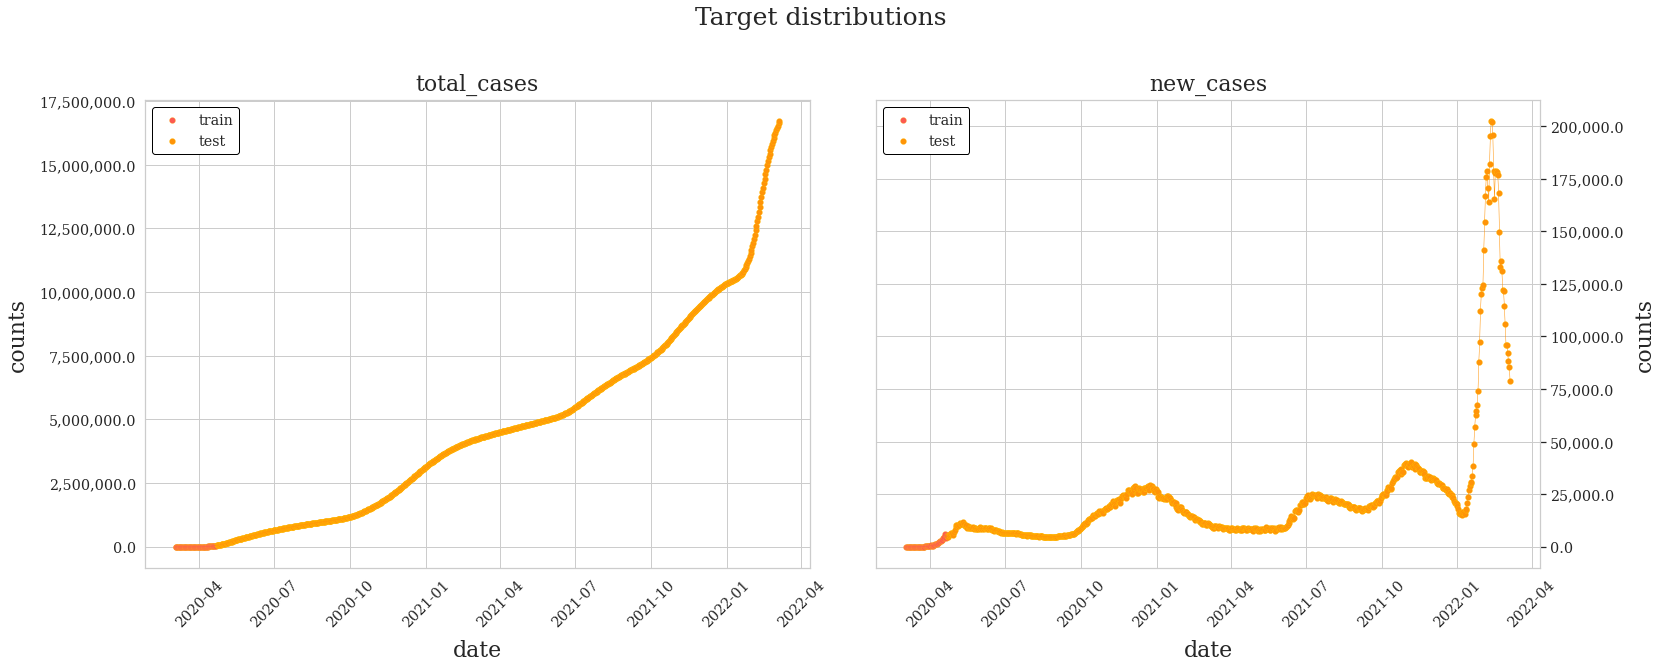

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(25, 10))
target_names = list(train_y.columns)

plot_target_distributions(fig, ax,
                          data={"train": train_y, 
                                "test": test_y},
                          target_names=target_names,
                          titles=["Total confirmed cases of COVID-19", 
                                  "New confirmed cases of COVID-19"],
                          colors={"train": "xkcd:coral",
                                  "test": "xkcd:tangerine"},
                          suptitle="Target distributions",
                          xlabel="date",
                          ylabel="counts")

Число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.


### 2.1 Linear Regression with basis functions

Используя линейную регрессию, обучим модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html


In [17]:
from sklearn.linear_model import LinearRegression

Базисные функции ${\phi_{i}}$ – это, например:
- результат *feature extraction*;
- расширение линейной модели на нелинейные зависимости
(например, ${\phi_{j}(x) = x^{j}}$);
- локальные функции, которые существенно не равны нулю
только в небольшой области (например, гауссовские базисные
функции ${\phi_{j}(x) = e^{(x-\mu_j)^{2} \over 2s^{2}}}$;

Пронумеруем наши дни (начиная с единицы)

In [18]:
test_X.shape[0]

684

In [19]:
train_day_nums = np.arange(0, train_X.shape[0]).reshape(-1, 1)
test_day_nums = np.arange(train_X.shape[0], train_X.shape[0] + test_X.shape[0]).reshape(-1, 1)

Логарифмируем целевые переменные

In [20]:
train_log_y = np.log(train_y)
test_log_y = np.log(test_y)

Обучим линейную регрессию

In [21]:
lin_reg = LinearRegression()
lin_reg.fit(train_day_nums,
            np.array(train_log_y.total_cases.values).reshape(-1, 1))

LinearRegression()

In [22]:
pred_train_y_pd = pd.DataFrame()
pred_train_y_pd["total_cases"] = np.round(np.exp(lin_reg.predict(train_day_nums).flatten()))

pred_test_y_pd = pd.DataFrame()
pred_test_y_pd["total_cases"] = np.round(np.exp(lin_reg.predict(test_day_nums).flatten()))

In [23]:
pred_train_y_pd.index = train_y.index
pred_test_y_pd.index = test_y.index

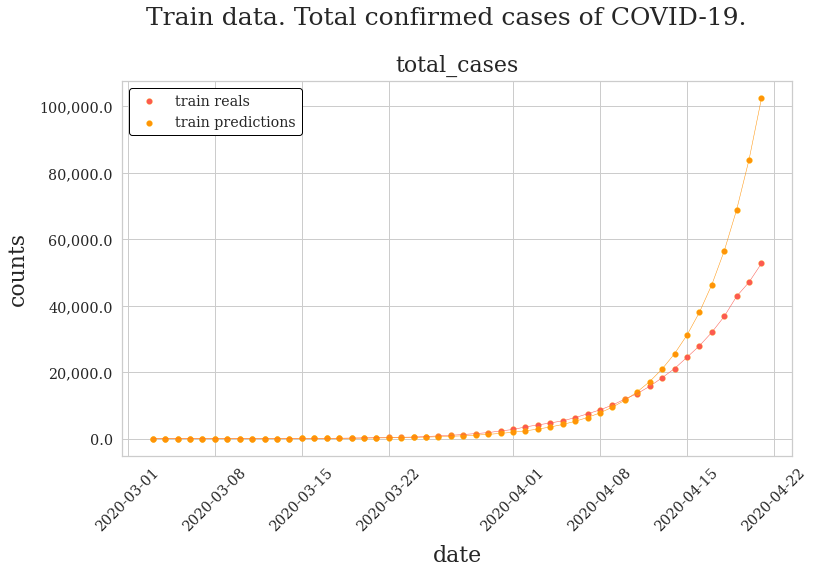

In [24]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

plot_target_distributions(fig, ax,
                          data={"train reals": train_y, 
                                "train predictions": pred_train_y_pd},
                          target_names=["total_cases"],
                          titles=["Total confirmed cases of COVID-19"],
                          colors={"train reals": "xkcd:coral",
                                  "train predictions": "xkcd:tangerine"},
                          suptitle="Train data. Total confirmed cases of COVID-19.",
                          xlabel="date",
                          ylabel="counts")

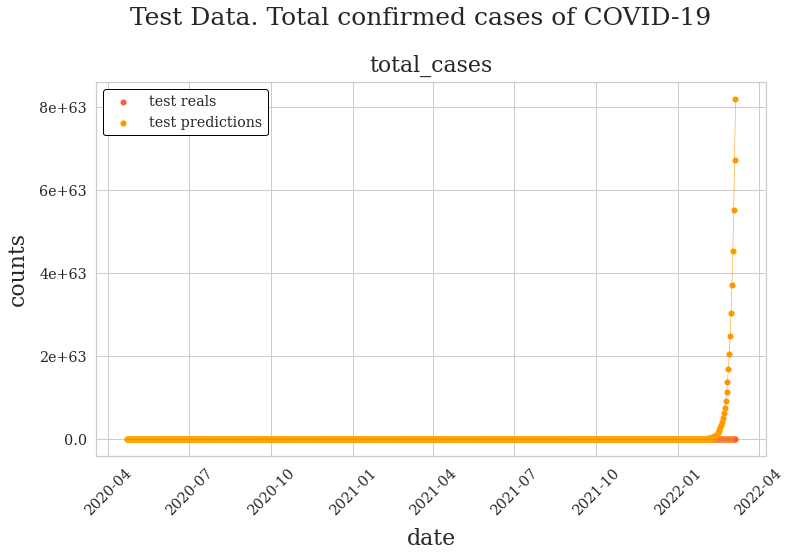

In [25]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

plot_target_distributions(fig, ax,
                          data={"test reals": test_y, 
                                "test predictions": pred_test_y_pd},
                          target_names=["total_cases"],
                          titles=["Total confirmed cases of COVID-19 on Test Data"],
                          colors={"test reals": "xkcd:coral",
                                  "test predictions": "xkcd:tangerine"},
                          suptitle="Test Data. Total confirmed cases of COVID-19",
                          xlabel="date",
                          ylabel="counts")

### 2.2 Gaussian basis function in Linear Regression

Найдём апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оценим, исходя из нашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

$$
{p(\mathrm{w}) = \mathcal{N} (\mathrm{w} \mid \mu_{0}, \Sigma_{0})}
$$

In [26]:
class GaussianDistribution:
    def __init__(self, mean, cov):
        self.mean = mean
        self.cov = cov

    def __str__(self):
        s = f"""Gaussian: \nmean={self.mean} \ncov=\n{self.cov}
        """
        return s

В качестве априорного выберем нормальное с нулевым средним и диагональной ковариационной матрицей с ${L_{1}}$-регуляризацией

$$
{p(\mathrm{w}) = \mathcal{N} (\mathrm{w} \mid \mathbb {0}, {1 \over \alpha} \mathbb {E})}
$$

In [27]:
inv_alpha = 1e4
prior_distribution = GaussianDistribution(mean=np.zeros(2), 
                                          cov=np.eye(2)*inv_alpha)

In [28]:
print(prior_distribution)

Gaussian: 
mean=[0. 0.] 
cov=
[[10000.     0.]
 [    0. 10000.]]
        


Найдем апостериорное распределение (3 лекция)

$$
{p(\mathrm{w} \mid t) = \mathcal{N} (\mathrm{w} \mid \mu_{N}, \Sigma_{N})}
\text{,}$$

$$
{\mu_{n} = \Sigma_{N} (\Sigma_{0}^{-1} \mu_{0} + {1 \over \sigma^{2}} \mathrm \Phi^{\mathrm {T}} \mathrm {t})}$$

$$
{\Sigma_{n} = (\Sigma_{0}^{-1} + {1 \over \sigma^{2}} \mathrm \Phi^{\mathrm {T}} \mathrm {\Phi})^{-1}}
$$

Здесь ${\Phi = (\phi_{j}(x_{i}))_{i,j}}$, т.е. матрица признаков (полученных в качестве базисных функций)

In [29]:
sigma_0_inv = np.linalg.inv(prior_distribution.cov)
mu_0 = prior_distribution.mean

variance = np.var(
    train_log_y.total_cases - np.log(pred_train_y_pd.total_cases),
    ddof=1
)
print(f"Variance: {variance:.4}")

Fi = np.hstack((
    np.ones(50).reshape(-1, 1),
    train_day_nums.reshape(-1, 1)
))
t = np.log(train_y.total_cases)

Variance: 0.1253


In [30]:
sigma_N = np.linalg.inv(sigma_0_inv + Fi.T @ Fi / variance)
mu_N = sigma_N @ (sigma_0_inv @ mu_0 + Fi.T @ t / variance)

In [31]:
posterior_distribution = GaussianDistribution(mean=mu_N, 
                                              cov=sigma_N)

In [32]:
print(posterior_distribution)

Gaussian: 
mean=[1.82073538 0.19829097] 
cov=
[[ 9.73210284e-03 -2.94912207e-04]
 [-2.94912207e-04  1.20372360e-05]]
        


### 2.3 Sampling of many different exponents

Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).

In [34]:
test_feature_matrix = np.hstack((
    np.ones(test_y.shape[0]).reshape(-1,1),
    test_day_nums.reshape(-1, 1)
))

In [35]:
posterior_gen_w = np.random.multivariate_normal(
    posterior_distribution.mean, posterior_distribution.cov, 200
)
posterior_pred_y_train = np.exp(posterior_gen_w @ Fi.T)
posterior_pred_y_test = np.exp(posterior_gen_w @ test_feature_matrix.T)

In [38]:
display(posterior_pred_y_train.shape)
display(posterior_pred_y_test.shape)

(200, 50)

(200, 684)

In [39]:
display(np.mean(posterior_pred_y_train, axis=0).shape)
display(np.mean(posterior_pred_y_test, axis=0).shape)

(50,)

(684,)

In [40]:
def plot_posterior_sample_lines(fig, ax, real_total_case, posterior_pred_y,
                                sampling_posterior_preds, mean_posterior_preds,
                                colors, suptitle, x_ticks,
                                xlabel, ylabel):
    fig.subplots_adjust(bottom=0.2, top=0.85, wspace=0.1)
    fig.suptitle(suptitle, fontsize=25)
    fig.align_labels(axs=ax)

    ax.set_xlabel(xlabel, fontsize=22, labelpad=10)
    ax.set_ylabel(ylabel, fontsize=22, labelpad=10)
    ax.ticklabel_format(style='sci', axis='y')
    ax.yaxis.set_label_position("left")

    ax.scatter(x=x_ticks, y=real_total_case.values,
               label="Reals", color=colors["Reals"], 
               marker="*", s=15**2, edgecolor="gold", lw=0.2)
    ax.plot(x_ticks, real_total_case.values, color=colors["Reals"])

    for y in posterior_pred_y:
        ax.plot(x_ticks, y, color=colors["Sampling"], lw=0.05)

    ax.scatter(x=x_ticks, y=mean_posterior_preds,
               label="Means", color=colors["Means"], 
               marker="o", s=8**2, edgecolor="gold", lw=0.2)
    ax.plot(x_ticks, mean_posterior_preds, color=colors["Means"])
        
    legend = ax.legend(framealpha=1)
    ax.legend(loc="upper left", fontsize=24)
    frame = legend.get_frame()
    frame.set_facecolor("white")
    frame.set_edgecolor("black")
        
    vals = ax.get_yticks()
    ax.set_yticklabels(["{:,}".format(x) for x in vals])
    ax.xaxis.set_tick_params(rotation=45)

    plt.show()

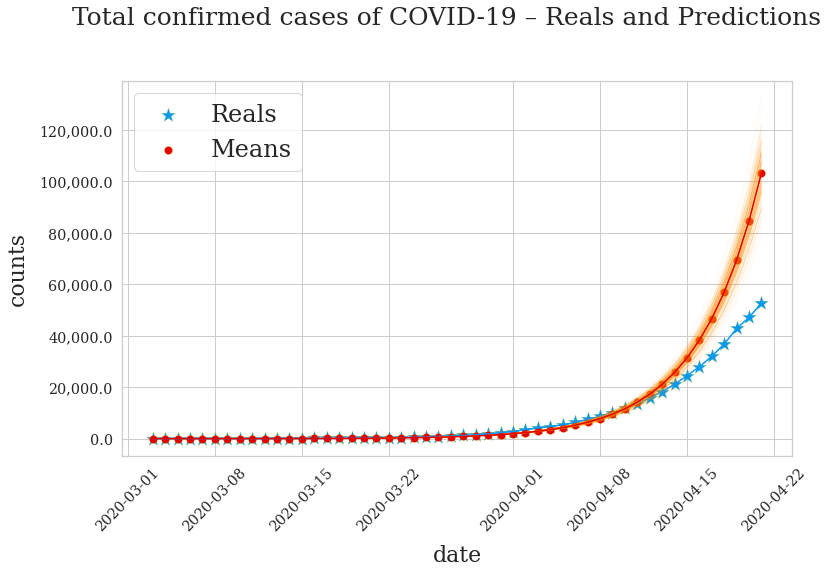

In [41]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

plot_posterior_sample_lines(fig, ax,
                          real_total_case=train_y.total_cases,
                          posterior_pred_y=posterior_pred_y_train,
                          sampling_posterior_preds=posterior_pred_y_train,
                          mean_posterior_preds=np.mean(posterior_pred_y_train, axis=0),
                          colors={"Reals": "xkcd:azure",
                                  "Sampling": "xkcd:tangerine",
                                  "Means": "xkcd:red"},
                          suptitle="Total confirmed cases of COVID-19 – Reals and Predictions",
                          x_ticks=train_y.total_cases.index,
                          xlabel="date",
                          ylabel="counts")

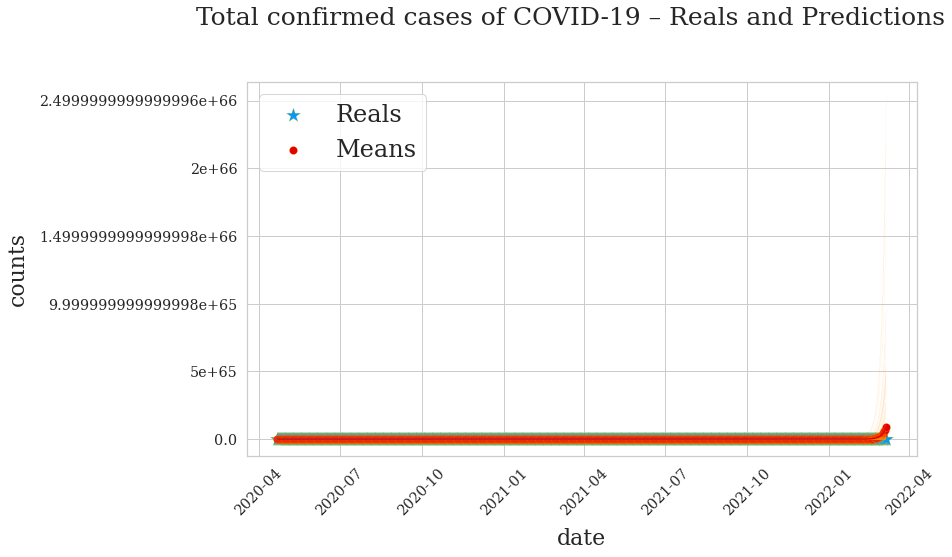

In [43]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

plot_posterior_sample_lines(fig, ax,
                          real_total_case=test_y.total_cases,
                          posterior_pred_y=posterior_pred_y_test,
                          sampling_posterior_preds=posterior_pred_y_test,
                          mean_posterior_preds=np.mean(posterior_pred_y_test, axis=0),
                          colors={"Reals": "xkcd:azure",
                                  "Sampling": "xkcd:tangerine",
                                  "Means": "xkcd:red"},
                          suptitle="Total confirmed cases of COVID-19 – Reals and Predictions",
                          x_ticks=test_y.total_cases.index,
                          xlabel="date",
                          ylabel="counts")

Предсказания случаев коронавируса в России к 1 мая, к 1 июня и к 1 сентября, исходя из сэмплов.

In [44]:
from datetime import datetime

In [45]:
first_may = (datetime(2020, 5, 1) - train_date_begin).days
first_june = (datetime(2020, 6, 1) - train_date_begin).days
first_sep = (datetime(2020, 9, 1) - train_date_begin).days
feature_one_day_matrix = np.array([
    np.ones(3),
    [first_may, first_june, first_sep]
])

In [46]:
posterior_gen_w.shape

(200, 2)

In [47]:
feature_one_day_matrix.shape

(2, 3)

In [48]:
one_day_target_predictions = np.exp(posterior_gen_w @ feature_one_day_matrix)

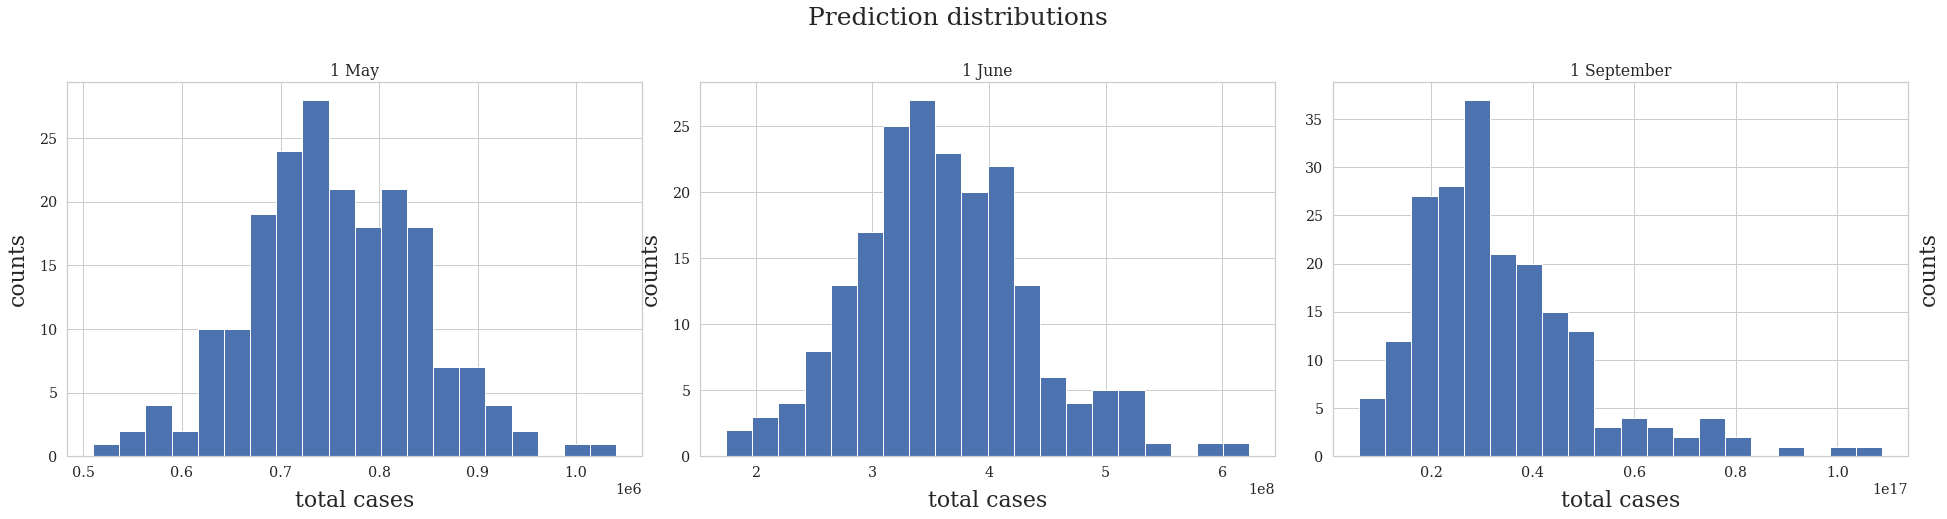

In [49]:
fig, ax = plt.subplots(1, 3, figsize=(33, 8))
fig.subplots_adjust(bottom=0.2, top=0.85, wspace=0.1)
fig.suptitle("Prediction distributions", fontsize=25)
fig.align_labels(axs=ax)

for i in range(3):
    ax[i].set_xlabel("total cases", fontsize=22, labelpad=10)
    ax[i].set_ylabel("counts", fontsize=22, labelpad=10)
    ax[i].grid("black")

ax[0].set_title("1 May")
ax[0].yaxis.set_label_position("left")
ax[0].hist(one_day_target_predictions[:, 0], bins=20)

ax[1].set_title("1 June")
ax[1].hist(one_day_target_predictions[:, 1], bins=20)

ax[2].set_title("1 September")
ax[2].yaxis.set_label_position("right")
ax[2].hist(one_day_target_predictions[:, 2], bins=20)

plt.show()

## Part III: Sigmoid Linear Regression

Предсказания экспоненциальной модели получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана:

${\displaystyle \Phi(x)={\frac {1}{\sqrt {2\pi}}}\int _{-\infty}^{x}e^{-t^{2}/2}\ dt}$

Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от t.

### 3.1 

Предложим способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.

Очевидное соображение, заключается в том, что мы можем продифференцировать сигмоиду под знаком интеграла. Полученный результат прологарифмируем по основанию $e$.

$$
\ln({d \Phi(x) \over dt}) = w_{0} + w_{1}t + w_{2}t^{2}, w_0 = (1, \dots, 1 )^{\mathrm T} \in \mathbb {R^{m}}, \text {where m - numbers of features} 
$$

$${
{d \Phi(x) \over dt} = \text {new_cases}
}$$

Тогда имеем следующее:

$${
\ln({\mathrm {new\_cases}}) = w_{0} + w_{1}t + w_{2}t^{2}
\\
\text {total_cases} = \mathrm {cumsum(} \mathrm {exp}(w_{0} + w_{1}t + w_{2}t^{2}) \text{)}
}$$


Повторим предыдущий пайплайн

Добавим в матрицу признаков $\Phi$ квадраты признака train_day_nums

In [50]:
Fi = np.hstack((
    Fi,
    (train_day_nums**2).reshape(-1,1)
))

In [51]:
lin_reg = LinearRegression()
lin_reg.fit(Fi[:, 1:],
            np.array(train_log_y.new_cases.values).reshape(-1, 1))

LinearRegression()

In [52]:
pred_train_y_pd = pd.DataFrame({
    "total_cases": np.cumsum(np.round(np.exp(lin_reg.predict(Fi[:, 1:]).flatten())))
}, index=train_y.index)

test_feature_matrix = np.hstack((
    test_day_nums.reshape(-1,1),
    (test_day_nums**2).reshape(-1,1)
))
pred_test_y_pd = pd.DataFrame({
    "total_cases": np.cumsum(np.round(np.exp(lin_reg.predict(test_feature_matrix).flatten())))
}, index=test_y.index)


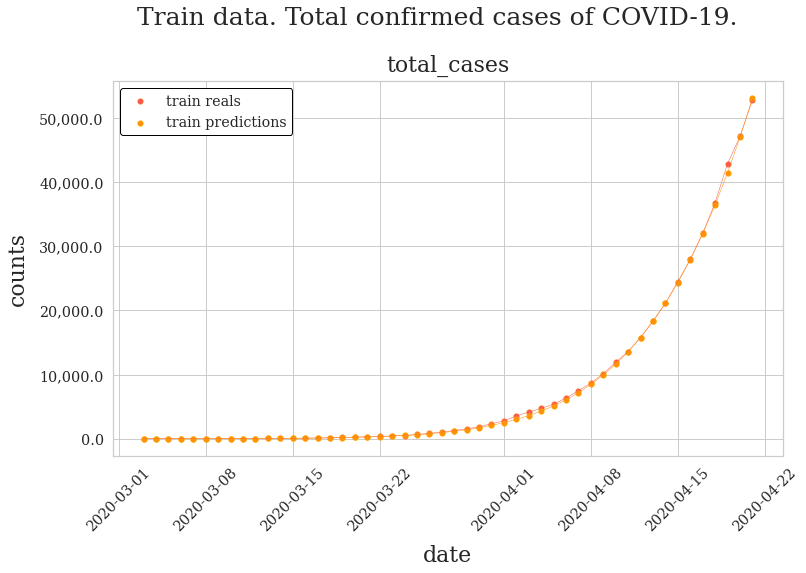

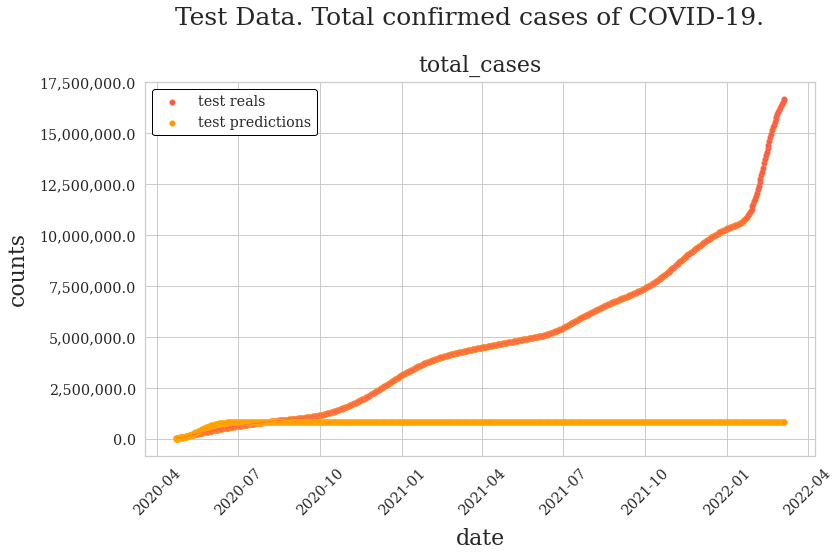

In [53]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
plot_target_distributions(fig, ax,
                          data={"train reals": train_y, 
                                "train predictions": pred_train_y_pd},
                          target_names=["total_cases"],
                          titles=["Total confirmed cases of COVID-19 on Train Data"],
                          colors={"train reals": "xkcd:coral",
                                  "train predictions": "xkcd:tangerine"},
                          suptitle="Train data. Total confirmed cases of COVID-19.",
                          xlabel="date",
                          ylabel="counts")

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
plot_target_distributions(fig, ax,
                          data={"test reals": test_y, 
                                "test predictions": pred_test_y_pd},
                          target_names=["total_cases"],
                          titles=["Total confirmed cases of COVID-19 on Test Data"],
                          colors={"test reals": "xkcd:coral",
                                  "test predictions": "xkcd:tangerine"},
                          suptitle="Test Data. Total confirmed cases of COVID-19.",
                          xlabel="date",
                          ylabel="counts")

__Вывод:__

- Как видно, по графикам, качество на тренировочных данных очень хорошее.
- Сигмоида насыщается вдали от центра, поэтому не может точно аппроксимировать функцию на всей области

### 3.2

Обучим эти параметры на датасете случаев коронавируса в России. Найдем апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оценим, исходя из вашей же максимальной апостериорной модели.

In [54]:
inv_alpha = 1e4
prior_distribution = GaussianDistribution(mean=np.zeros(3), 
                                          cov=np.eye(3)*inv_alpha)

In [55]:
print(prior_distribution)

Gaussian: 
mean=[0. 0. 0.] 
cov=
[[10000.     0.     0.]
 [    0. 10000.     0.]
 [    0.     0. 10000.]]
        


In [56]:
sigma_0_inv = np.linalg.inv(prior_distribution.cov)
mu_0 = prior_distribution.mean

variance = np.var(
    train_log_y.total_cases - np.log(pred_train_y_pd.total_cases),
    ddof=1
)
print(f"Variance: {variance:.4}")
t = np.log(train_y.total_cases)

Variance: 0.05138


In [57]:
sigma_N = np.linalg.inv(sigma_0_inv + Fi.T @ Fi / variance)
mu_N = sigma_N @ (sigma_0_inv @ mu_0 + Fi.T @ t / variance)

In [58]:
posterior_distribution = GaussianDistribution(mean=mu_N, 
                                              cov=sigma_N)

In [59]:
print(posterior_distribution)

Gaussian: 
mean=[ 1.14740935  0.28245684 -0.00171767] 
cov=
[[ 8.54626226e-03 -6.90489631e-04  1.16244046e-05]
 [-6.90489631e-04  7.61339365e-05 -1.45305101e-06]
 [ 1.16244046e-05 -1.45305101e-06  2.96541051e-08]]
        


### 3.3

Посэмплируем много разных сигмоид из апостериорного распределения, построим графики. 

Ответим на следующие вопросы:

- Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? 

Построим эмпирическое предсказательное распределение, нарисуем графики. 

Ответим на следующие вопросы:
- Каков прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? 
- В оптимистичном сценарии (10-й процентиль)?

In [60]:
test_feature_matrix = np.hstack((
    np.ones(test_y.shape[0]).reshape(-1,1),
    test_feature_matrix
))

In [61]:
posterior_gen_w = np.random.multivariate_normal(
    posterior_distribution.mean, posterior_distribution.cov, 200
)
posterior_pred_y_train = np.exp(posterior_gen_w @ Fi.T)
posterior_pred_y_test = np.exp(posterior_gen_w @ test_feature_matrix.T)

In [62]:
posterior_pred_y_train.shape

(200, 50)

In [63]:
np.mean(posterior_pred_y_train, axis=0).shape

(50,)

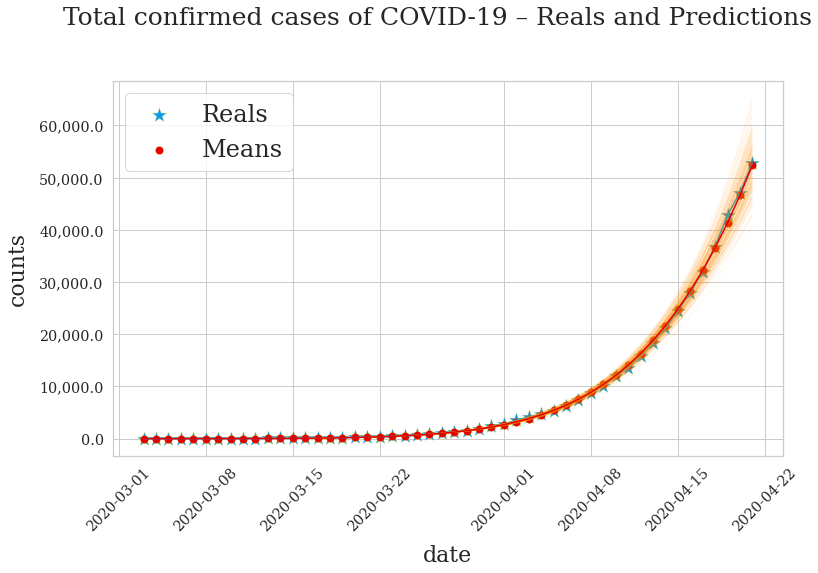

In [65]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

plot_posterior_sample_lines(fig, ax,
                          real_total_case=train_y.total_cases,
                          posterior_pred_y=posterior_pred_y_train,
                          sampling_posterior_preds=posterior_pred_y_train,
                          mean_posterior_preds=np.mean(posterior_pred_y_train, axis=0),
                          colors={"Reals": "xkcd:azure",
                                  "Sampling": "xkcd:tangerine",
                                  "Means": "xkcd:red"},
                          suptitle="Total confirmed cases of COVID-19 – Reals and Predictions",
                          x_ticks=train_y.total_cases.index,
                          xlabel="date",
                          ylabel="counts")

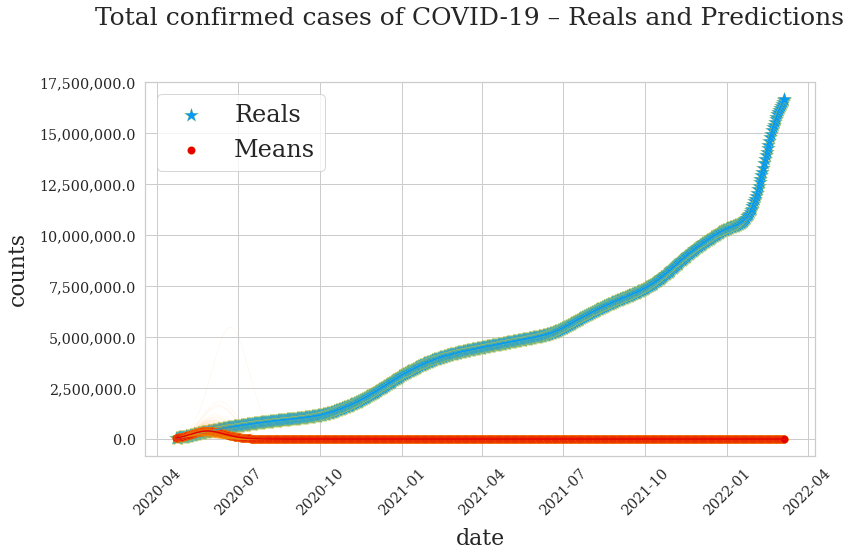

In [66]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

plot_posterior_sample_lines(fig, ax,
                          real_total_case=test_y.total_cases,
                          posterior_pred_y=posterior_pred_y_test,
                          sampling_posterior_preds=posterior_pred_y_test,
                          mean_posterior_preds=np.mean(posterior_pred_y_test, axis=0),
                          colors={"Reals": "xkcd:azure",
                                  "Sampling": "xkcd:tangerine",
                                  "Means": "xkcd:red"},
                          suptitle="Total confirmed cases of COVID-19 – Reals and Predictions",
                          x_ticks=test_y.total_cases.index,
                          xlabel="date",
                          ylabel="counts")